In [1]:
import time
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Import packages for visualization of results
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
# Iport packages for evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
df_1 = pd.read_csv(r"C:\Users\flore\OneDrive\Documents\CSUN\Fall24\COMP_541\Project\VideoGame\games.csv")

In [3]:
df_2 = pd.read_csv(r"C:\Users\flore\OneDrive\Documents\CSUN\Fall24\COMP_541\Project\VideoGame\all_games.csv")

In [4]:
df_1.columns = ['Name','Release date','Estimated Owners','Peak CCU','Required age','Price','Unknown1',
              'Unknown2','About the game','Supported languages','Full audio languages','Reviews','Header Image','Website',
              'Support url','Support email','Windows','Mac', 'Linux','User score','Metacritic url'
              ,'Positive','Negative','Score rank','Achievements','Recommendations','Unknown3','Notes',
              'Average playtime forever','Average playtime two weeks','Median playtime forever','Median playtime two weeks',
              'Developers','Publishers','Categories','Genres','Tags','Screenshots','Movies']

In [5]:
df_2.columns = ['Name','Platform','Release Date','Summary','Meta Score','User Review']

In [6]:
df_1.shape

(97410, 39)

In [7]:
df_2.shape

(18800, 6)

In [8]:
df_1 = df_1.drop(['Developers','User score','Average playtime forever','Average playtime two weeks','Median playtime forever','Median playtime two weeks','Recommendations','Estimated Owners','About the game','Reviews','Unknown1','Unknown2','Unknown3', 'Supported languages','Full audio languages','Header Image' ,'Website', 'Support url', 'Support email', 'Notes', 'Metacritic url', 'Achievements', 'Screenshots', 'Movies','Publishers','Categories','Tags'], axis=1)

In [9]:
df_2 = df_2.drop(['Summary','Release Date','Platform'], axis=1)

In [12]:
VG_dataset = pd.merge(df_1, df_2, on='Name', how='inner')

In [13]:
VG_dataset.shape

(5860, 14)

In [14]:
len_VG_dataset = len(VG_dataset)
print(f"Number of matching instances in 'Name': {len_VG_dataset}")

Number of matching instances in 'Name': 5860


In [15]:
print(VG_dataset.isna().sum())

Name            0
Release date    0
Peak CCU        0
Required age    0
Price           0
Windows         0
Mac             0
Linux           0
Positive        0
Negative        0
Score rank      0
Genres          3
Meta Score      0
User Review     0
dtype: int64


In [16]:
VG_dataset.head()

,Name,Release date,Peak CCU,Required age,Price,Windows,Mac,Linux,Positive,Negative,Score rank,Genres,Meta Score,User Review
0,Alien Breed 3: Descent,"Nov 17, 2010",3,0,9.99,True,False,False,0,349,134,Action,68,6.7
1,Alien Breed 3: Descent,"Nov 17, 2010",3,0,9.99,True,False,False,0,349,134,Action,64,5.1
2,Alien Breed 3: Descent,"Nov 17, 2010",3,0,9.99,True,False,False,0,349,134,Action,64,4.9
3,Deadfall Adventures,"Nov 15, 2013",4,0,19.99,True,False,True,0,1716,628,"Action,Adventure",53,6.9
4,Deadfall Adventures,"Nov 15, 2013",4,0,19.99,True,False,True,0,1716,628,"Action,Adventure",43,7.7


In [17]:
VG_dataset = VG_dataset.dropna()

In [18]:
VG_dataset = VG_dataset.drop(['Name'], axis = 1)

In [19]:
VG_dataset.shape

(5857, 13)

In [20]:
VG_dataset['Release date'] = VG_dataset['Release date'].str.extract(r'(\d{4})')
VG_dataset['Release date'] = pd.to_numeric(VG_dataset['Release date'], errors='coerce')
VG_dataset = VG_dataset[VG_dataset['Release date'] >= 2014]


In [21]:
len_VG_filter_by_year = len(VG_dataset)
print(f"Number of Games instances release after 2014': {len_VG_filter_by_year}")

Number of Games instances release after 2014': 4573


In [22]:
VG_dataset['Genres'] = VG_dataset['Genres'].str.split(',')
unique_tags = set(tag for sublist in VG_dataset['Genres'] for tag in sublist)
one_hot_encoded_genres = VG_dataset['Genres'].str.join('|').str.get_dummies()
VG_dataset = pd.concat([VG_dataset, one_hot_encoded_genres], axis=1)
VG_dataset.drop('Genres', axis=1, inplace=True) #don't need 'Genres' feature any more

In [23]:
Q1 = VG_dataset['Negative'].quantile(0.25)
Q3 = VG_dataset['Negative'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
VG_outliers_filter = VG_dataset[(VG_dataset['Negative'] >= lower_bound) & (VG_dataset['Negative'] <= upper_bound)]

In [24]:
total_outliers = len(VG_dataset) - len(VG_outliers_filter)
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Total Number of Outliers: {total_outliers}")

Lower Bound: -6519.0
Upper Bound: 11465.0
Total Number of Outliers: 693


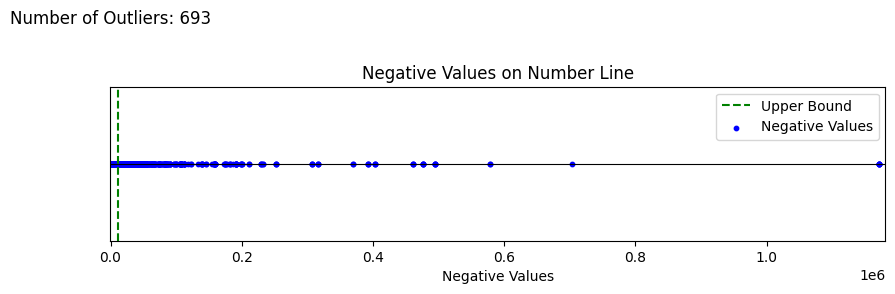

In [25]:
plt.figure(figsize=(10, 2))
plt.title("Negative Values on Number Line")
plt.axhline(0, color='black', lw=0.8)  
plt.text(0, 0.1, f'Number of Outliers: {total_outliers}', fontsize=12, ha='center', color='black')
plt.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
plt.scatter(VG_dataset['Negative'], np.zeros(len(VG_dataset)), color='blue', label='Negative Values', s=10)
plt.xlim(VG_dataset['Negative'].min() - 100, VG_dataset['Negative'].max()+10000)  # x-axis limits
plt.yticks([])  
plt.xlabel("Negative Values")
plt.legend()
plt.grid(False)
plt.show()

In [26]:
VG_dataset = VG_outliers_filter

In [27]:
scaler = MinMaxScaler()
normalization_data = scaler.fit_transform(VG_dataset[['Release date', 'Peak CCU','Required age','Price', 'Positive', 'Negative','Score rank','Meta Score']])
VG_dataset[['Release date', 'Peak CCU','Required age','Price', 'Positive', 'Negative', 'Score rank','Meta Score']] = normalization_data

In [28]:
VG_dataset.iloc[0]

Release date                  0.2
Peak CCU                  0.00007
Required age                  0.0
Price                    0.074954
Windows                      True
Mac                         False
Linux                       False
Positive                      0.0
Negative                 0.018055
Score rank               0.007046
Meta Score               0.657534
User Review                   7.8
Action                          1
Adventure                       1
Animation & Modeling            0
Casual                          0
Design & Illustration           0
Early Access                    0
Free To Play                    0
Free to Play                    0
Gore                            0
Indie                           1
Massively Multiplayer           0
Nudity                          0
RPG                             1
Racing                          0
Sexual Content                  0
Simulation                      0
Sports                          0
Strategy      

In [29]:
genre_columns = VG_dataset.columns[12:]
threshold = 0.10 * len(VG_dataset)
filtered_genres = [col for col in genre_columns if VG_dataset[col].sum() >= threshold]
columns_to_keep = VG_dataset.columns[1:12].tolist() + filtered_genres
VG_dataset = VG_dataset[columns_to_keep]

In [30]:
unique_windows = VG_dataset['Windows'].unique()
print(unique_windows)

[ True]


In [31]:
# Remove the feature 'Window' because all the instance has the same value 
# redundant feature 
VG_dataset= VG_dataset.drop(['Windows'], axis=1)

In [32]:
VG_dataset = VG_dataset[VG_dataset['User Review'] != 'tbd']

In [33]:
VG_dataset.loc[:, 'User Review'] = pd.to_numeric(VG_dataset['User Review'], errors='coerce')

In [34]:
correlation_matrix = VG_dataset.corr()
meta_score_correlation = correlation_matrix['Meta Score']
print("Correlation with 'Meta Score':")
print(meta_score_correlation)

Correlation with 'Meta Score':
Peak CCU        0.102442
Required age   -0.097415
Price           0.100313
Mac             0.104554
Linux           0.092904
Positive        0.004297
Negative        0.263749
Score rank      0.002806
Meta Score      1.000000
User Review     0.519950
Action         -0.040038
Adventure       0.003518
Casual         -0.000480
Indie           0.060891
RPG             0.046574
Simulation     -0.008883
Strategy        0.019927
Name: Meta Score, dtype: float64


In [35]:
low_correlation_features = meta_score_correlation[abs(meta_score_correlation) < 0.015].index.tolist()
VG_dataset.drop(columns=low_correlation_features, inplace=True)

In [36]:
VG_dataset.head()

,Peak CCU,Required age,Price,Mac,Linux,Negative,Meta Score,User Review,Action,Indie,RPG,Strategy
11,0.000070,0.000000,0.074954,False,False,0.018055,0.657534,7.8,1,1,1,0
12,0.000279,0.000000,0.004950,False,False,0.181683,0.821918,4.0,1,1,0,0
13,0.000279,0.000000,0.004950,False,False,0.181683,0.739726,5.4,1,1,0,0
16,0.000070,0.000000,0.124956,False,False,0.036633,0.397260,4.8,0,1,0,0
17,0.003175,0.722222,0.199960,False,False,0.184300,0.794521,8.3,0,0,1,0


In [37]:
VG_dataset.shape

(3511, 12)

In [38]:
VG_dataset.dtypes

Peak CCU        float64
Required age    float64
Price           float64
Mac                bool
Linux              bool
Negative        float64
Meta Score      float64
User Review      object
Action            int64
Indie             int64
RPG               int64
Strategy          int64
dtype: object

In [39]:
fixed_num_instances = len(VG_dataset)
VG_dataset = VG_dataset.sample(n=fixed_num_instances, random_state=42)

In [40]:
y =VG_dataset['Meta Score']

In [41]:
X = VG_dataset.drop(['Meta Score'], axis=1)

In [42]:
X = pd.DataFrame(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [45]:
param_grid = {
    'n_neighbors': [3,5,7,9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [46]:
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

In [47]:
st=time.time()
grid_search.fit(X_train_scaled, np.ravel(y_train))
et = time.time()
elapsed_time = et - st
print(f"Run time: {elapsed_time}")

Run time: 3.3269858360290527


In [48]:
best_knn = grid_search.best_estimator_
y_pred_test = best_knn.predict(scaler.transform(X_test))
y_pred_train = best_knn.predict(scaler.transform(X_train))

In [49]:
min_value = min(min(y_test), min(y_pred_test))
max_value = max(max(y_test), max(y_pred_test))

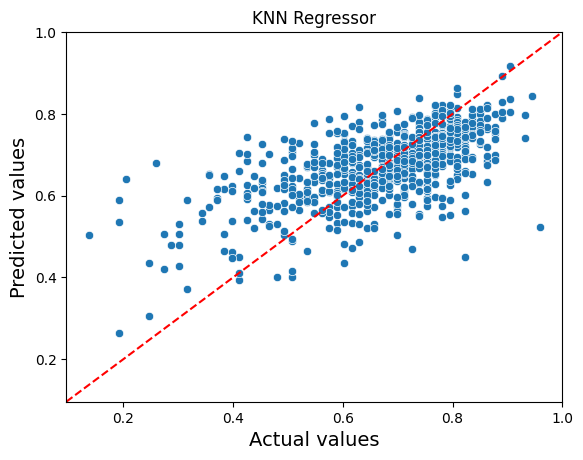

In [50]:
p = sns.scatterplot(x=y_test, y=y_pred_test)
plt.title("KNN Regressor")
p.set_xlabel("Actual values", fontsize=14)
p.set_ylabel("Predicted values", fontsize=14)
plt.axline((min_value,min_value), (max_value, max_value), color='r', ls='--')

In [51]:
print("MSE: ", metrics.mean_squared_error(y_test, y_pred_test))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred_test))
print("R sqaure: ", metrics. r2_score(y_test, y_pred_test))

MSE:  0.011655798910916856
MAE:  0.08286730880724696
R sqaure:  0.38864669696819465


In [52]:
train_accuracy = r2_score(y_train, y_pred_train)
test_accuracy = r2_score(y_test, y_pred_test)

print("Train Accuracy (R^2):", train_accuracy)
print("Test Accuracy (R^2):", test_accuracy)

Train Accuracy (R^2): 0.996379160776159
Test Accuracy (R^2): 0.38864669696819465
